In [73]:
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch
from matplotlib import pyplot as plt
import numpy as np


In [74]:
class AlexNet(nn.Module):
  def __init__(self,num_classes=100):
    super().__init__()
    self.features = nn.Sequential(
      #nn.AdaptiveAvgPool2d((256,256)),
      nn.Conv2d(1,64,kernel_size=11,stride=4,padding=2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3,stride=2),

      nn.Conv2d(64,192,kernel_size=5,stride=1,padding=2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3,stride=2),
      
      nn.Conv2d(192,384,kernel_size=3,stride=1,padding=1),
      nn.ReLU(),

      nn.Conv2d(384,256,kernel_size=3,stride=1,padding=1),
      nn.ReLU(),
           
      nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = 3, stride = 2)

    );

    self.classifier = nn.Sequential(
        nn.AdaptiveAvgPool2d((6,6)),
        nn.Flatten(),
        nn.Dropout(p = 0.5),
        nn.Linear(256*6*6,4096),
        nn.ReLU(),
        nn.Dropout(p = 0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Linear(4096, num_classes)
    )
  def forward(self,x):
    x = self.features(x);
    x = self.classifier(x)
    return x

In [148]:
from google.colab import files,drive
drive.mount('/content/drive')

def alexnet( pretrained=False,**kwargs):
    model = AlexNet(**kwargs)
    model.to('cuda:0')

    if(pretrained):
      model.load_state_dict(torch.load('./drive/MyDrive/NN/AlexNet.pt'))
    return model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
### Loading Datasets

In [77]:
img_size = 312
training_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.Resize((img_size ,img_size )),transforms.ToTensor()]),

)

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.Resize((img_size,img_size )),transforms.ToTensor()]),
)

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

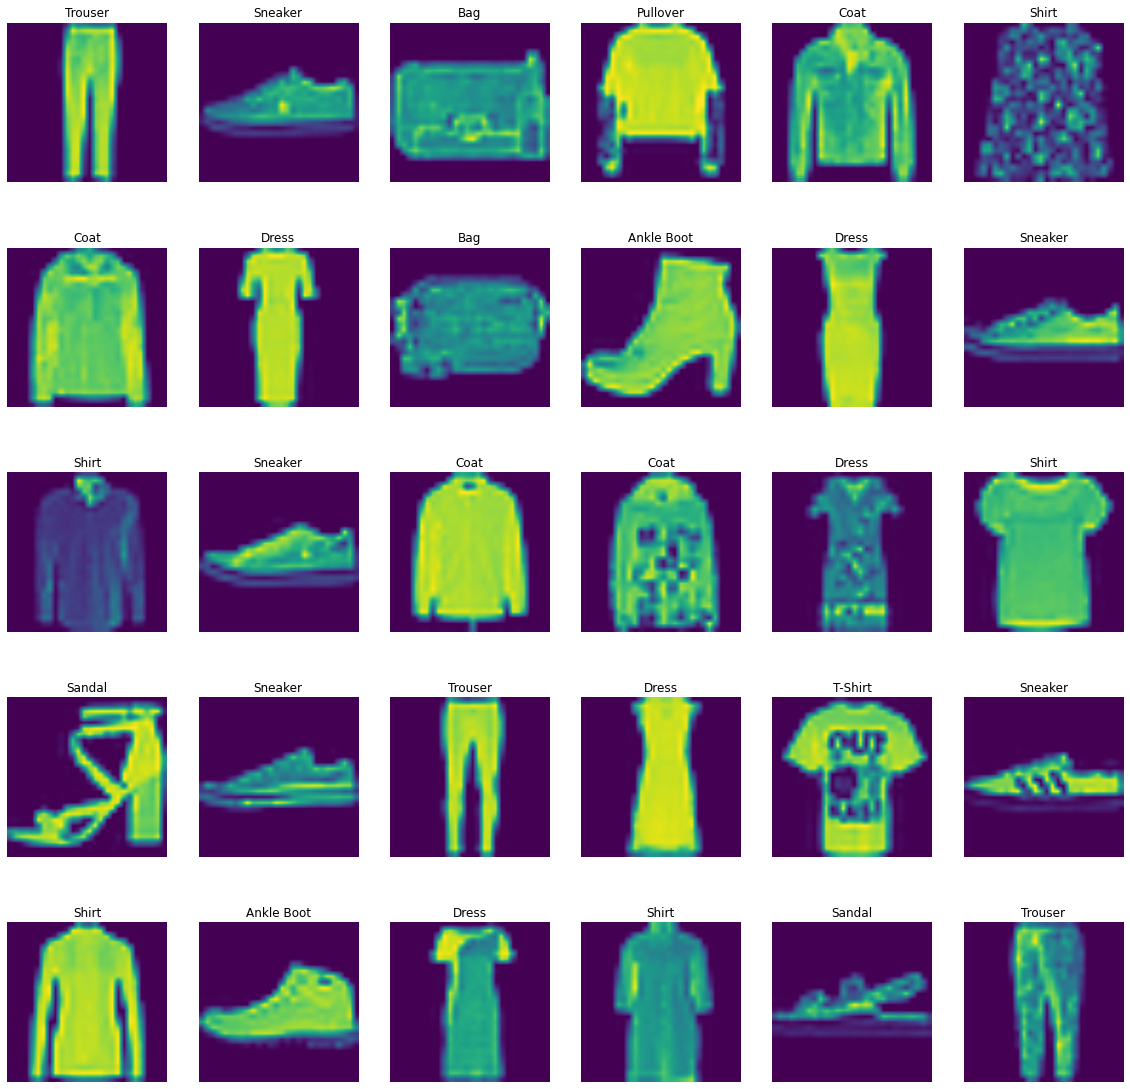

In [119]:
random_id = np.random.randint(len(training_data),size=(30))
plt.figure(figsize=(20,20))
plt.title('Dataset Sample')
for i,id in enumerate(random_id):
  plt.subplot(5,6,i+1)
  image = training_data[id][0].squeeze()
  label = labels_map[training_data[id][1]]
  plt.title(label)
  plt.axis('off')
  plt.imshow(image)

In [120]:

ds = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.Resize((img_size,img_size)),transforms.ToTensor()]),
    target_transform=transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)),
)
trainloader = torch.utils.data.DataLoader(ds, batch_size=128,
                                          shuffle=True, num_workers=2)

tds = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.Resize((img_size,img_size)),transforms.ToTensor()]),
    target_transform=transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)
testloader = torch.utils.data.DataLoader(tds, batch_size=5000,
                                          shuffle=True, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [121]:
mynet = alexnet(num_classes=10)

In [122]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mynet.parameters(),lr=0.01,momentum=0.45)

In [83]:
running_loss = 0
e_loops = 40

mynet.train()

losses = []
accuracies = []
running_accr = 0
for epoch in range(20):
  running_loss = 0.0
  running_accr = 0.0
  for i,data in enumerate(trainloader,0):
    inputs,labels = data
    inputs = inputs.to('cuda:0')
    labels = labels.to('cuda:0')
    
    optimizer.zero_grad()

    outputs = mynet(inputs)
    ly = torch.argmax(labels,axis=1)
    lo = torch.argmax(outputs,axis=1)
    loss = criterion(outputs,ly)
    accr = (ly == lo).sum().detach().item()
    running_accr += accr
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.detach().item()
    if i % e_loops == e_loops-1:    # print every 2000 mini-batches
        running_loss /= e_loops
        running_accr /= e_loops * (128)
        print('[%d, %5d] loss: %.3f - accuracy %.3f' %
              (epoch + 1, i + 1, running_loss ,running_accr))
        losses.append(running_loss)
        accuracies.append(running_accr)
        running_loss = 0.0
        running_accr = 0.0
  torch.save(mynet.state_dict(), "./drive/MyDrive/NN/AlexNet.pt")

[1,    40] loss: 2.303 - accuracy 0.099
[1,    80] loss: 2.302 - accuracy 0.102
[1,   120] loss: 2.302 - accuracy 0.099
[1,   160] loss: 2.301 - accuracy 0.112
[1,   200] loss: 2.301 - accuracy 0.104
[1,   240] loss: 2.301 - accuracy 0.106
[1,   280] loss: 2.300 - accuracy 0.120
[1,   320] loss: 2.298 - accuracy 0.163
[1,   360] loss: 2.296 - accuracy 0.195
[1,   400] loss: 2.290 - accuracy 0.207
[1,   440] loss: 2.261 - accuracy 0.203
[2,    40] loss: 1.178 - accuracy 0.527
[2,    80] loss: 1.056 - accuracy 0.579
[2,   120] loss: 1.005 - accuracy 0.589
[2,   160] loss: 0.970 - accuracy 0.610
[2,   200] loss: 0.934 - accuracy 0.639
[2,   240] loss: 0.904 - accuracy 0.651
[2,   280] loss: 0.874 - accuracy 0.656
[2,   320] loss: 0.863 - accuracy 0.663
[2,   360] loss: 0.862 - accuracy 0.659
[2,   400] loss: 0.826 - accuracy 0.678
[2,   440] loss: 0.817 - accuracy 0.680
[3,    40] loss: 0.769 - accuracy 0.705
[3,    80] loss: 0.804 - accuracy 0.693
[3,   120] loss: 0.737 - accuracy 0.707


KeyboardInterrupt: ignored

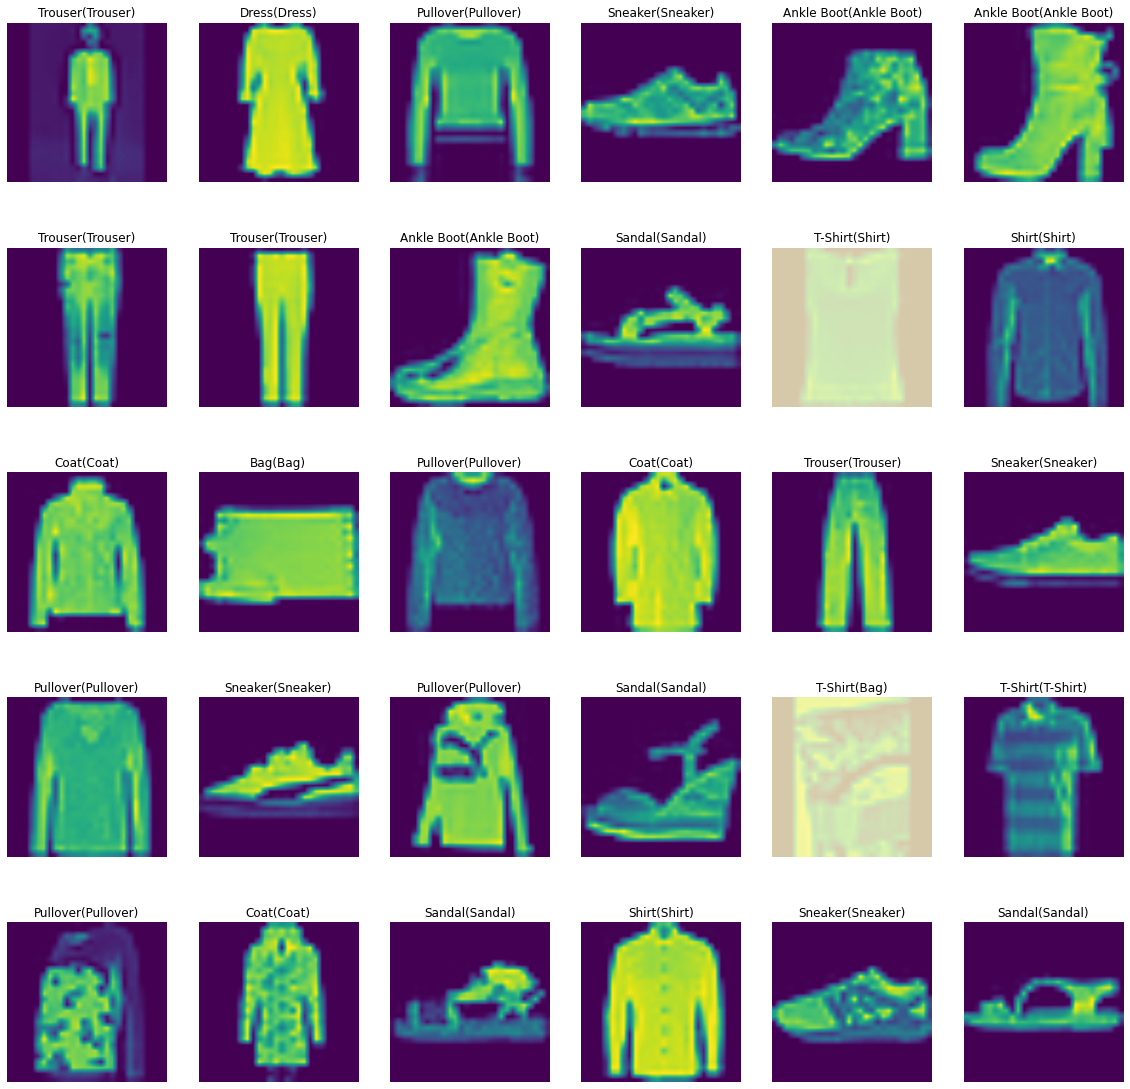

In [84]:
mynet.eval()
random_id = np.random.randint(len(test_data),size=(30))
plt.figure(figsize=(20,20),facecolor='white')
for i,id in enumerate(random_id):
  plt.subplot(5,6,i+1)
  image = test_data[id][0].squeeze()
  olabel = np.argmax(mynet(image.unsqueeze(0).unsqueeze(0).to('cuda:0')).detach().cpu().numpy())
  olabel = labels_map[olabel]
  
  
 
  label = labels_map[test_data[id][1]] + f"({olabel})"
  plt.title(label)
  plt.axis('off')
  plt.imshow(image)

  if(olabel != labels_map[test_data[id][1]] ):
    plt.imshow(np.ones(shape=image.shape),alpha=0.8,cmap='magma_r')
  

In [ ]:
def measureAccuracy():
  total = 0
  correct = 0
  with torch.no_grad():
      mynet.eval()
      for data in testloader:

          inputs,labels = data
          inputs = inputs.to('cuda:0')
          labels = labels.to('cuda:0')
          outputs = mynet(inputs)
          _, predicted = torch.max(outputs.data, 1)
          _, expected = torch.max(labels,1)
          total += labels.size(0)
        
          correct += (predicted == expected).sum().detach().item()

  return  correct / total

In [133]:
e_accr = []

for i in range(len(accuracies)//11):
  sub =accuracies[(i*11):(i*11+11)]
  e_accr.append(sum(sub) / len(sub))

In [140]:
e_loss = []

for i in range(len(losses)//11):
  sub =losses[(i*11):(i*11+11)]
  e_loss.append(sum(sub) / len(sub))

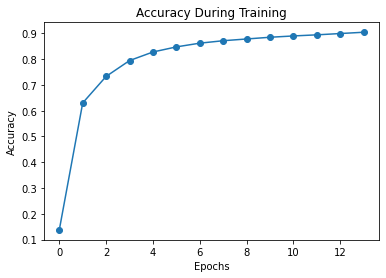

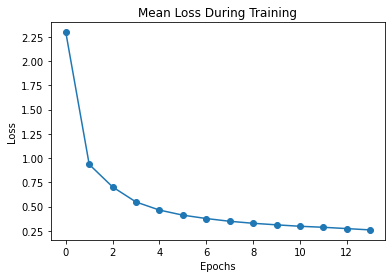

In [143]:
plt.title('Accuracy During Training')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.plot(e_accr,marker='o')
plt.show()
plt.title('Mean Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(e_loss,marker='o')

In [117]:
print(f"Accuracy On Test Data : {measureAccuracy()}")

Accuracy On Test Data : 0.9153166666666667


In [147]:
torch.save(mynet.state_dict(), "./drive/MyDrive/NN/AlexNet.pt")

In [146]:
!mkdir -p ./drive/MyDrive/NN/